In [1]:
import pandas as pd
import sys
import os
import jieba
import warnings
warnings.filterwarnings("ignore")

train_file = 'train_data.txt'
test_file = 'test_data.txt'

vocab_file = 'vocab.txt'
category_file = 'category.txt'
output_folder = './run_text_rnn'
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [2]:
import tensorflow as tf
import numpy as np
import math

tf.logging.set_verbosity(tf.logging.INFO)

In [3]:
def get_default_params():
    return tf.contrib.training.HParams(
        num_embedding_size = 20,
        num_timesteps = 50,
        num_lstm_nodes = [32, 32],
        num_lstm_layers = 2,
        num_fc_nodes = 32,
        batch_size = 100,
        clip_lstm_grads = 1.0,
        learning_rate = 0.001,
        num_word_threshold = 5
    )
hps = get_default_params()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [4]:
class Vocab:
    def __init__(self, filename, num_word_threshold):
        self._word_to_id = {}
        self._unk = -1
        self._num_word_threshold = num_word_threshold
        self._read_dict(filename)
    
    def _read_dict(self, filename):
        with open(filename, 'r') as f:
            lines = f.readlines()
        for line in lines:
            word, frequency = line.strip('\r\n').split('\t')
            frequency = int(frequency)
            if frequency < self._num_word_threshold:
                continue
            idx = len(self._word_to_id)
            if word == '<UNK>':
                self._unk = idx
            self._word_to_id[word] = idx
    
    def word_to_id(self, word):
        return self._word_to_id.get(word, self._unk)
    
    @property
    def unk(self):
        return self._unk
    
    def size(self):
        return len(self._word_to_id)
    
    def sentence_to_id(self, sentence):
        word_ids = [self.word_to_id(cur_word) \
                    for cur_word in jieba.cut(sentence)]
        return word_ids


class CategoryDict:
    def __init__(self, filename):
        self._category_to_id = {}
        with open(filename, 'r') as f:
            lines = f.readlines()
        for line in lines:
            category = line.strip('\r\n')
            idx = len(self._category_to_id)
            self._category_to_id[category] = idx
    
    def size(self):
        return len(self._category_to_id)
        
    def category_to_id(self, category):
        if not category in self._category_to_id:
            raise Exception("%s is not in our category list" % category)
        return self._category_to_id[category]
        
vocab = Vocab(vocab_file, hps.num_word_threshold)
vocab_size = vocab.size()
tf.logging.info('vocab_size: %d' % vocab_size)

category_vocab = CategoryDict(category_file)
num_classes = category_vocab.size()
tf.logging.info('num_classes: %d' % num_classes)
test_str = 'news'
tf.logging.info(
    'label: %s, id: %d' % (
        test_str,
        category_vocab.category_to_id(test_str)))

INFO:tensorflow:vocab_size: 27672
INFO:tensorflow:num_classes: 8
INFO:tensorflow:label: news, id: 1


In [6]:
class TextDataSet:
    def __init__(self, filename, vocab, category_vocab, num_timesteps):
        self._vocab = vocab
        self._category_vocab = category_vocab
        self._num_timesteps = num_timesteps
        # matrix
        self._inputs = []
        # vector
        self._outputs = []
        self._indicator = 0
        self._parse_file(filename)
    
    def _parse_file(self, filename):
        tf.logging.info('Loading data from %s', filename)
        with open(filename, 'r') as f:
            lines = f.readlines()
        for line in lines:
            label = line.strip('\r\n').split(',')[0]
            content = ""
            for one in line.strip('\r\n').split(',')[1:]:
                content += one
            #print(content)
            id_label = self._category_vocab.category_to_id(label)
            #print(id_label)
            id_words = self._vocab.sentence_to_id(content)
            #print(id_words)
            id_words = id_words[0: self._num_timesteps]
            padding_num = self._num_timesteps - len(id_words)
            id_words = id_words + [
                self._vocab.unk for i in range(padding_num)]
            self._inputs.append(id_words)
            self._outputs.append(id_label)
        self._inputs = np.asarray(self._inputs, dtype = np.int32)
        self._outputs = np.asarray(self._outputs, dtype = np.int32)
        self._random_shuffle()
        self._num_examples = len(self._inputs)
    
    def _random_shuffle(self):
        p = np.random.permutation(len(self._inputs))
        self._inputs = self._inputs[p]
        self._outputs = self._outputs[p]
    
    def num_examples(self):
        return self._num_examples
    
    def next_batch(self, batch_size):
        end_indicator = self._indicator + batch_size
        if end_indicator > len(self._inputs):
            self._random_shuffle()
            self._indicator = 0
            end_indicator = batch_size
        if end_indicator > len(self._inputs):
            raise Exception("batch_size: %d is too large" % batch_size)
        
        batch_inputs = self._inputs[self._indicator: end_indicator]
        batch_outputs = self._outputs[self._indicator: end_indicator]
        self._indicator = end_indicator
        return batch_inputs, batch_outputs
            
train_dataset = TextDataSet(
    train_file, vocab, category_vocab, hps.num_timesteps) 
test_dataset = TextDataSet(
    test_file, vocab, category_vocab, hps.num_timesteps)

print(train_dataset.num_examples())
print(test_dataset.num_examples())

print(train_dataset.next_batch(2))
print(test_dataset.next_batch(2))

INFO:tensorflow:Loading data from train_data.txt
INFO:tensorflow:Loading data from test_data.txt
4067
1854
(array([[   10, 10403,     0, 24362,     0,     0,  5723,  6554,  7529,
         4739,   983,    13, 10403,     0,  4739,     0,    75,    73,
           25,    14,    36,    20,   289,  1034,    32, 19125,   462,
            1,     0, 15097,   218,  2187,  3699,     3, 10403,     0,
            0,   600,     0,     0,  2187,   284,   152,    37,  3031,
           56,    20,     1,  1115,     2],
       [   10,   182,    21,   234, 16221,  1361,   114,     0,   113,
         1782,    34,     6,  1853,     7,   528,    22,    14,    55,
          164,    27,    83,   182,  7341,   122,   182,  2401,  1339,
           49,    20,   398,    21,    30,   182,   246,  5773,   947,
        16221,     1,  1361,   877,    35,  1318,     1, 12209,   690,
           72,   234,    66,  1782,  1822]]), array([2, 1]))
(array([[   10,  1703,     0, 23845,  3842,   564,   170,    90,  1048,
     

In [9]:
train_dataset = TextDataSet(
    train_file, vocab, category_vocab, hps.num_timesteps)
test_dataset = TextDataSet(
    test_file, vocab, category_vocab, hps.num_timesteps)
print(train_dataset.next_batch(100))
print(test_dataset.next_batch(100))

INFO:tensorflow:Loading data from train_data.txt
INFO:tensorflow:Loading data from test_data.txt
(array([[   10, 12109,  4510, ...,  8534,    13,   643],
       [   10,  2068,    74, ...,   105,  5193,   890],
       [   10,     0,    79, ...,     2,     0,   158],
       ...,
       [   10,   191,   301, ...,   382,    53, 18920],
       [   10,    80,    26, ..., 17173,     4,   593],
       [   10, 23145,  2591, ..., 15021,  9832,  1664]]), array([1, 1, 3, 1, 1, 1, 0, 2, 5, 1, 3, 3, 3, 1, 1, 2, 6, 1, 5, 1, 1, 1,
       5, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 3, 3, 2, 1, 1, 0, 1, 1, 1,
       3, 1, 1, 2, 3, 1, 1, 3, 1, 2, 3, 2, 5, 2, 3, 1, 1, 0, 1, 1, 1, 1,
       3, 3, 1, 5, 1, 2, 1, 5, 1, 1, 1, 2, 0, 3, 3, 1, 1, 2, 1, 1, 0, 1,
       3, 1, 1, 0, 5, 3, 1, 1, 1, 1, 1, 5]))
(array([[   10,  1927,   107, ...,     1,   756, 14886],
       [   10,   914,    11, ...,  2302,  1827,   277],
       [   10,     0,     0, ...,     3,   115,    25],
       ...,
       [   10, 11665,   215, ..., 

In [10]:
def create_model(hps, vocab_size, num_classes):
    num_timesteps = hps.num_timesteps
    batch_size = hps.batch_size
    
    inputs = tf.placeholder(tf.int32, (batch_size, num_timesteps))
    outputs = tf.placeholder(tf.int32, (batch_size, ))
    keep_prob = tf.placeholder(tf.float32, name = 'keep_prob') #dropout, 有百分之n的可能保留值
    
    global_step = tf.Variable(
        tf.zeros([], tf.int64), name='global_step', trainable=False)
    
    with tf.name_scope('embedding'):
        embeddings = tf.Variable(tf.random_uniform([vocab_size, hps.num_embedding_size], -1, 1))
        embed_inputs = tf.nn.embedding_lookup(embeddings, inputs)
    
    scale = 1.0/math.sqrt(hps.num_embedding_size + hps.num_lstm_nodes[-1])/3.0
    
    lstm_init = tf.random_uniform_initializer(-scale,scale)
    with tf.variable_scope('lstm_nn', initializer=lstm_init, reuse=tf.AUTO_REUSE):
        cells = []
        for i in range(hps.num_lstm_layers):
            cell = tf.contrib.rnn.BasicLSTMCell( #LSTM node
                hps.num_lstm_nodes[i],
                state_is_tuple = True)
            cell = tf.contrib.rnn.DropoutWrapper( #dropout layer
                cell,
                output_keep_prob = keep_prob)
            cells.append(cell) #add up
        cell = tf.contrib.rnn.MultiRNNCell(cells) #封装
        
        initial_state = cell.zero_state(hps.batch_size, tf.float32)
        #rnn_outputs: [batch_size, num_timesteps, lstm_outputs]
        rnn_outputs, _ = tf.nn.dynamic_rnn(
            cell, embed_inputs,initial_state=initial_state) #包含了每一步的输出
        last = rnn_outputs[:, -1, :] #每一个batch_size取最后一个输出
    
    fc_init = tf.uniform_unit_scaling_initializer(factor=1.0)
    with tf.variable_scope('fc', initializer=fc_init, reuse=tf.AUTO_REUSE):
        fc = tf.layers.dense(last, hps.num_fc_nodes, name='fc1')
        fc1_dropout = tf.contrib.layers.dropout(fc, keep_prob) #简单起见，用相同的keep_prob
        logits = tf.layers.dense(fc1_dropout, num_classes, name='fc2') #将输出映射到类别上
    
    with tf.name_scope('metrics'):
        softmax_loss = tf.nn.sparse_softmax_cross_entropy_with_logits( #对label做one_hot, 对logits做softmax，之后将两者进行交叉熵损失函数计算
            logits = logits, labels = outputs
        )
        loss = tf.reduce_mean(softmax_loss)
        # [0, 1, 5, 4, 2] -> softmax:2
        y_pred = tf.argmax(
            tf.nn.softmax(logits),1,output_type=tf.int32)
        correct_pred = tf.equal(outputs, y_pred)
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32)) 
    
    with tf.name_scope('train_op'): #优化
        tvars = tf.trainable_variables()
        for var in tvars:
            tf.logging.info('variable name: %s' % (var.name))
        #截断梯度
        grads, _ = tf.clip_by_global_norm(
            tf.gradients(loss,tvars), hps.clip_lstm_grads)
        #clips_lstm_grad 限制梯度
        optimizer = tf.train.AdamOptimizer(hps.learning_rate)
        train_op = optimizer.apply_gradients(
            zip(grads, tvars),global_step=global_step)
        return ((inputs, outputs, keep_prob),
                (loss, accuracy),
                (train_op, global_step))

In [11]:
warnings.filterwarnings("ignore")
placeholders, metrics, others = create_model(
    hps, vocab_size, num_classes)
inputs, outputs, keep_prob = placeholders
loss, accuracy = metrics
train_op, global_step = others

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Use keras.layers.dense instead.
INFO:tensorflow:variable name: embedding/Variable:0
INFO:tensorflow:variable name: lstm_nn/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0
INFO:tensorflow:variable name: lstm_nn/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0
INFO:tensorflow:variable name: lstm_n

In [12]:
def eval_holdout(sess, accuracy, dataset_for_test, batch_size):
    num_batches = dataset_for_test.num_examples() // batch_size
    tf.logging.info("Eval holdout: num_examples = %d, batch_size = %d",
                    dataset_for_test.num_examples(), batch_size)
    accuracy_vals = []
    for i in range(num_batches):
        batch_inputs, batch_labels = dataset_for_test.next_batch(batch_size)
        accuracy_val = sess.run(accuracy,
                                feed_dict = {
                                    inputs: batch_inputs,
                                    outputs: batch_labels,
                                    keep_prob: 1.0,
                                })
        accuracy_vals.append(accuracy_val)
    return np.mean(accuracy_vals)

In [44]:
init_op = tf.global_variables_initializer()
glostep = []
loss_v = []
acc_v = []
t_acc_v = []
train_keep_prob_value = 0.8
test_keep_prob_value = 1.0

num_train_steps = 5000
#test
with tf.Session() as sess:
    writer = tf.summary.FileWriter("d:\Documents\Jupyter notebook\AI Project3",sess.graph)
    sess.run(init_op)
    for i in range(num_train_steps):
        batch_inputs, batch_labels = train_dataset.next_batch(
            hps.batch_size)
        outputs_val = sess.run([loss, accuracy, train_op, global_step],
                           feed_dict = {
                               inputs: batch_inputs,
                               outputs: batch_labels,
                               keep_prob: train_keep_prob_value
                           })
        loss_val, accuracy_val, _, global_step_val = outputs_val
        if global_step_val % 50 == 0:
            tf.logging.info("Step: %5d, loss: %3.3f, accuracy: %3.3f"
                            % (global_step_val, loss_val, accuracy_val))
            glostep.append(global_step_val)
            loss_v.append(loss_val)
            acc_v.append(accuracy_val)
        if global_step_val % 200 == 0:
            accuracy_test = eval_holdout(sess, accuracy, test_dataset, hps.batch_size)
            tf.logging.info("Step: %5d, test_accuracy: %3.3f"
                            % (global_step_val, accuracy_test))
            t_acc_v.append(accuracy_test)
writer.close()

INFO:tensorflow:Step:    50, loss: 1.309, accuracy: 0.590
INFO:tensorflow:Step:   100, loss: 1.375, accuracy: 0.490
INFO:tensorflow:Step:   150, loss: 1.279, accuracy: 0.570
INFO:tensorflow:Step:   200, loss: 0.905, accuracy: 0.770
INFO:tensorflow:Eval holdout: num_examples = 1854, batch_size = 100
INFO:tensorflow:Step:   200, test_accuracy: 0.551
INFO:tensorflow:Step:   250, loss: 0.788, accuracy: 0.740
INFO:tensorflow:Step:   300, loss: 0.705, accuracy: 0.720
INFO:tensorflow:Step:   350, loss: 0.570, accuracy: 0.800
INFO:tensorflow:Step:   400, loss: 0.426, accuracy: 0.890
INFO:tensorflow:Eval holdout: num_examples = 1854, batch_size = 100
INFO:tensorflow:Step:   400, test_accuracy: 0.625
INFO:tensorflow:Step:   450, loss: 0.349, accuracy: 0.880
INFO:tensorflow:Step:   500, loss: 0.513, accuracy: 0.840
INFO:tensorflow:Step:   550, loss: 0.220, accuracy: 0.950
INFO:tensorflow:Step:   600, loss: 0.292, accuracy: 0.910
INFO:tensorflow:Eval holdout: num_examples = 1854, batch_size = 100


INFO:tensorflow:Step:  4800, loss: 0.032, accuracy: 0.980
INFO:tensorflow:Eval holdout: num_examples = 1854, batch_size = 100
INFO:tensorflow:Step:  4800, test_accuracy: 0.647
INFO:tensorflow:Step:  4850, loss: 0.026, accuracy: 0.990
INFO:tensorflow:Step:  4900, loss: 0.030, accuracy: 0.980
INFO:tensorflow:Step:  4950, loss: 0.002, accuracy: 1.000
INFO:tensorflow:Step:  5000, loss: 0.017, accuracy: 0.990
INFO:tensorflow:Eval holdout: num_examples = 1854, batch_size = 100
INFO:tensorflow:Step:  5000, test_accuracy: 0.631


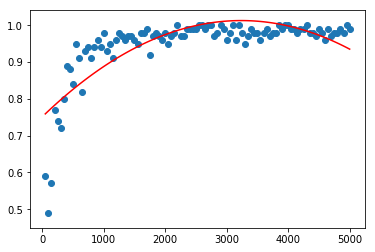

In [61]:
import matplotlib.pyplot as plt

fig=plt.figure()  #生成图片框架
ax=fig.add_subplot(1,1,1)  #连续性的画图
ax.scatter(glostep,acc_v)
parameter = np.polyfit(glostep, acc_v, 2)
f = np.poly1d(parameter)
ax.plot(glostep,f(glostep),c='r')
plt.ion() #不会show一下就停止显示（python新功能）
plt.show()